## 

## Testing with a simple linear dynamical system

We will use the streaming DMD algorithm to recover the characteristic frequencies of a simple scalar, linear dynamical system. In order to be able to use DMD for a scalar system, we will elevate the system to a higher-dimensional space by using time-lagged snapshots of the system state.


In [1]:
from dmdstream.dmd import StreamingDMD

from math import pi, cos, sin, sqrt
import random as rn
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt 

We start by defining the dynamical system under consideration and a helper function that will allow us to lift the system to higher dimensions:

In [10]:
# Coefficients
A1 = 10
A2 = 5
A3 = 1
A4 = 0.1

# Time step between system states
dt = 1.e-2

# System's characteristic frequencies
f1 = 6.3
f2 = 0.2

# Artificial noise covariance
noise_cov = 1e-5

# Number of lookback snapshots
nlookback = 1000

def dynamical_system(step: int):

    state = A1*cos(2*pi*f1*dt*step) + A2*cos(2*pi*f2*dt*step) + A3*sin(2*pi*f1*dt*step) + A4*sin(2*pi*f2*dt*step)
    return state

def lift(step: int, nlookback: int):

    lifted = []
    for i in range(step-nlookback, step):
        lifted.append(dynamical_system(i))

    # Add noise
    lifted = np.asarray(lifted)[:, np.newaxis] + sqrt(noise_cov)*np.random.random([nlookback, 1])
    
    return lifted

We will let the DMD algorithm observe the dynamical system for a while (num_states) by feeding it with pairs of consecutive system's states. The DMD algorithm will learn the linear operator that best describes (in the least squares sense) the dynamics of the system. 

In [11]:
# Maximum allowed rank of the learned operator
max_rank = 10

# Number of states to feed to the DMD algorithm
num_states = 501

# Instantiate the DMD class
sdmd = StreamingDMD(max_rank=max_rank)

# Initialise
xi = lift(0, nlookback)
yi = lift(1, nlookback)
sdmd.preprocess(xi, yi)

# Learn in streaming mode
for i in range(2, num_states):
    xi = yi
    yi= lift(i, nlookback)
    sdmd.update(xi, yi)

We can now compute the eigenvalues $\lambda_i$ (Ritz values) of the learned linear operator, which come in complex conjugate pairs and lie in the unit circle. The characteristic frequencies of the dynamical system are recovered as $f_i = \arg(\lambda_i)/(2\pi\Delta t)$, where $\Delta t$ is the time interval between system states.

In [12]:
emodes, evals = sdmd.compute_modes()

# Calculate frequencies
fdmd = np.angle(evals) /  (2*pi*dt)

# Calculate amplitudes
ydmd = []
for i in range(len(fdmd)):
    ydmd.append(norm(emodes[:, i])*abs(evals[i]))

# Sort frequencies by amplitude of the modes
fchar = fdmd[sorted(range(len(ydmd)), key=lambda x: ydmd[x], reverse=True)[:4]]
fchar = set(abs(fchar))

print(fchar)

{0.0, 6.499951134221493, 6.100115757215442}


In [13]:
fdmd

array([50.        , 50.        ,  6.49995113, -6.49995113,  6.10011576,
       -6.10011576,  0.        ,  0.        ,  1.71175833, -1.71175833])

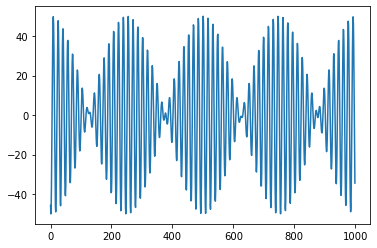

In [14]:
plt.plot(xi.ravel())